<a href="https://colab.research.google.com/github/ProfDoeg/Colegio_Invisible/blob/main/18_cuaderno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install eciespy eth_keys cryptos qrcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 2.7 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 1.3 MB 12.5 MB/s 
     |████████████████████████████████| 2.0 MB 14.2 MB/s 
     |████████████████████████████████| 105 kB 45.8 MB/s 
     |████████████████████████████████| 481 kB 49.7 MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.2-cp37-cp37m-linux_x86_64.whl size=1236752 sha256=79c22d396222a2da9f96c13ad023cd5d9204107c008d6b571d0e54fe99dd47f5
  Stored in directory: /root/.cache/pip/wheels/38/70/71/ca13ea3d36ccd0b3d0ec7d7a4ca67522048d695b556bba4f59
  Created wheel for qrcode: filename=qrcode-7.3.1-py3-none-any.whl size=40402 sha256=2a22fb939ad56b1357a20329ffdb4f6c28122f5bb09e96cfd3ef36d66d5d7c47
  Stored in directory: /root/.cache/pip/wheels/93/d7/39/a4111be2cfb8e679938aa671a37888b6afb1f9e7d748e94492
Successfully built cytoolz 

In [11]:
import ecies
import eth_keys
import coincurve
import hashlib

In [12]:
broad_message=b'''Tell the world something. Encrypt with AES key.
AES encrypt multiple copes of that key using a list of shared secrets.'''
print(broad_message.decode(),len(broad_message))

Tell the world something. Encrypt with AES key.
AES encrypt multiple copes of that key using a list of shared secrets. 118


In [13]:
from coincurve.utils import get_valid_secret

master_aes=get_valid_secret()
broad_message_aes=ecies.aes_encrypt(master_aes,broad_message)

Now we have an encrypted message and we want to distribute it so select key holders can open it. 

We will encrypt the `master_aes` encryption key (using aes) so that each recipient can access it using their special-unique encrypted copy.

**HOT DIGGITY DOG !!! HOW DO WE MAKE SURE ONLY THE SELECT KEY HOLDER CAN OPEN THEIR COPY ???**

#Diffie Helman Key Exchange...Broadcast

In [ ]:
privKey1 = ecies.utils.generate_eth_key()
privKey2 = ecies.utils.generate_eth_key()
privKey3 = ecies.utils.generate_eth_key()
print(privKey1, type(privKey1))
print(privKey2, type(privKey2))
print(privKey3, type(privKey3))

0xdca87f90bd5b6a44d8190d2457eeed81e7f433575fc8212684e3158534e62f5b <class 'eth_keys.datatypes.PrivateKey'>
0x655a6d66426d69f0ca6ea9c5fddd596a7adc5fb70d18cc543af714bb6697262d <class 'eth_keys.datatypes.PrivateKey'>
0x6641d7a39ffbb3296fcd16ba066a8caeeea8ab18d5ba4e007147e5d7084992fc <class 'eth_keys.datatypes.PrivateKey'>


In [ ]:
#convert from ecies private/public key to concurve private/public key

k1 = coincurve.PrivateKey(privKey1.to_bytes())
k2 = coincurve.PrivateKey(privKey2.to_bytes())
k3 = coincurve.PrivateKey(privKey2.to_bytes())

p1 = coincurve.PublicKey( privKey1.public_key.to_compressed_bytes() )
p2 = coincurve.PublicKey( privKey2.public_key.to_compressed_bytes() )
p3 = coincurve.PublicKey( privKey3.public_key.to_compressed_bytes() )

In [ ]:
shared12 = p2.multiply(k1.secret)
shared21 = p1.multiply(k2.secret)

In [ ]:
shared12.format().hex(),shared21.format().hex()

('03494315c53ff8f6eca88866fb289f4619f9c45750bf58a5d5b28ad1892257534c',
 '03494315c53ff8f6eca88866fb289f4619f9c45750bf58a5d5b28ad1892257534c')

In [14]:
from Crypto.Protocol.KDF import HKDF
AES_KEY_BYTES_LEN = 32
from Crypto.Hash import SHA256

In [ ]:
ps=[p1,p2,p3]
shared_secrets=[p.multiply(k1.secret) for p in ps]

In [ ]:
def shared_key(prvKey,pubKey):
  cc_prvKey=coincurve.PrivateKey(prvKey.to_bytes())
  cc_pubKey= coincurve.PublicKey( pubKey.to_compressed_bytes() )
  return HKDF(cc_pubKey.multiply(cc_prvKey.secret).format(), AES_KEY_BYTES_LEN, b"", SHA256)

In [ ]:
shared_key(privKey3,privKey1.public_key)

b'\xe6\xc0:D\xc2\xfdmi\x18a\x12\xdb\x97\xbe_\x1d\x0f)\xb2\xb3\x84\xd5)\xb4%\xa4\x86\xa1I\xab\x15 '

In [ ]:
shared_keys=[ HKDF(shared_secret.format(), AES_KEY_BYTES_LEN, b"", SHA256) for shared_secret in shared_secrets]

In [ ]:
access_keys=[ ecies.aes_encrypt(shared_key,master_aes) for shared_key in shared_keys]
print(len(b''.join(access_keys)))
access_keys

192


[b"\xb8\rH'9\xfa\xff\x07\x0f\x8a9\x7f\xa7\xdbK\xb7YO_Y2C\xd3M\xcf\x96\xb5\xe2\xf2\xe3\xda\xa6\x04\x80h\xb6\xbf6\xcc|u4\xca\xd8\xcb\x0b2/\xba\xef@\x8d\xeb1k\xb6)\x8b\xd8\xc7d\x18Q\xe0",
 b'\x19@\xe5Y\xf5$\xa0\xa6\xcf)0U>\xca\xcf\xb3\x14\x11c\xf3W\x1f\xfb\xdd"\xe5r!J\xac\x97\xe0\xe6{\x18\\p\xff\xdbE\x99U\xde\xf5\xfb\x93y\x9a\xb5\x96\xf7\xbc\x82]\x8b\xc4\x85\x146\xa8\x89\xa9\xdc\xe3',
 b'\x9d)\xb8\x90\x90f\xfc)N\xf0\xa9\x14\xab\x9c\x7f\xf7_\xd5r1C\x9cn\x05\x14\x9dH\x19\x91\x88E\xf8\r\xcd\xa7\xef\xe4\xa3\xe2\x1bA\xad\xebWK\x93\x9aP\xee\x03\xf1s~\x9a/A\xa6\xde\xcf\xcdJh$Z']

In [ ]:
ecies.aes_decrypt(shared_keys[0],access_keys[0])

b'\xb2p\xa7v\xa0_VM\x96\r\x02\xcf\xd7X\x81m\x06XW\x8e\xc8\xee:\r}\x0cd\xd8#E\xe2$'

In [ ]:
dist_keys=[ecies.aes_decrypt(*args)  for args in zip(shared_keys,access_keys)]
dist_keys

[b'\xb2p\xa7v\xa0_VM\x96\r\x02\xcf\xd7X\x81m\x06XW\x8e\xc8\xee:\r}\x0cd\xd8#E\xe2$',
 b'\xb2p\xa7v\xa0_VM\x96\r\x02\xcf\xd7X\x81m\x06XW\x8e\xc8\xee:\r}\x0cd\xd8#E\xe2$',
 b'\xb2p\xa7v\xa0_VM\x96\r\x02\xcf\xd7X\x81m\x06XW\x8e\xc8\xee:\r}\x0cd\xd8#E\xe2$']

In [ ]:
master_aes

b'\xb2p\xa7v\xa0_VM\x96\r\x02\xcf\xd7X\x81m\x06XW\x8e\xc8\xee:\r}\x0cd\xd8#E\xe2$'

In [ ]:
ecies.aes_decrypt(dist_keys[2],broad_message_aes)

b'Tell the world something. Encrypt with AES key.\nAES encrypt multiple copes of that key using a list of shared secrets.'

In [ ]:
mess2post=len(access_keys).to_bytes(1,'big')+b''.join(access_keys)+broad_message_aes

In [ ]:
mess2post

b'\x03\xb8\rH\'9\xfa\xff\x07\x0f\x8a9\x7f\xa7\xdbK\xb7YO_Y2C\xd3M\xcf\x96\xb5\xe2\xf2\xe3\xda\xa6\x04\x80h\xb6\xbf6\xcc|u4\xca\xd8\xcb\x0b2/\xba\xef@\x8d\xeb1k\xb6)\x8b\xd8\xc7d\x18Q\xe0\x19@\xe5Y\xf5$\xa0\xa6\xcf)0U>\xca\xcf\xb3\x14\x11c\xf3W\x1f\xfb\xdd"\xe5r!J\xac\x97\xe0\xe6{\x18\\p\xff\xdbE\x99U\xde\xf5\xfb\x93y\x9a\xb5\x96\xf7\xbc\x82]\x8b\xc4\x85\x146\xa8\x89\xa9\xdc\xe3\x9d)\xb8\x90\x90f\xfc)N\xf0\xa9\x14\xab\x9c\x7f\xf7_\xd5r1C\x9cn\x05\x14\x9dH\x19\x91\x88E\xf8\r\xcd\xa7\xef\xe4\xa3\xe2\x1bA\xad\xebWK\x93\x9aP\xee\x03\xf1s~\x9a/A\xa6\xde\xcf\xcdJh$Z/Jn*\xaa?^\xf0A\xb6\x90\x06mZ\xbdX\xf5\xdc^&.\xc8\xfb\xee\x01(9a\x1c\xcfz\xe2\xddJ\x17\xaev\xbd\xb9\x04yb\xfaU\'~\x9dT\xd0\x92\xb8\xca\x02\x18\xe7^-\xcf2\xac\x01\xef\x03\xd3\xf6|\x11\x0b@N\xf5\xfa\x12\n!\xc7\xc5\x15u\x0c\x99\xe1p\x85\x8e\'\\W\x83\x8b\x88p\x00\x0cl\x9b\xd0\x8f\xd9\xd1#\x05}\xa0]\x9b\x1f\xb6\xc1i\xbb\x00\xf3\x92\xf5F;U\xdb#8t\xf39\x8d`\x88\xee\xcb\xb0%\x88\x12\xdbj\x00,\xbd\xbf\x1d"C\x97\x0ef\x94\x9cA5\x1a'

In [ ]:
len(mess2post)

343

In [ ]:
len(broad_message)

118

In [ ]:
! git clone https://github.com/ProfDoeg/Colegio_Invisible.git
! pip install cryptos

Cloning into 'Colegio_Invisible'...
remote: Enumerating objects: 1185, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 1185 (delta 34), reused 0 (delta 0), pack-reused 1130
Receiving objects: 100% (1185/1185), 137.51 MiB | 33.31 MiB/s, done.
Resolving deltas: 100% (817/817), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from PIL import Image
import numpy as np

def grey_imgarr(imgarr):
  return imgarr[:,:,:3].mean(axis=2).astype('uint8')

def message_2_bit_array(message,mode=None):
    '''This function takes in a message as string, bytestring or hextring.
    If hexstring input the set mode='hex' '''
    if type(message)==bytes:
        hex_str=message.hex()
    elif (type(message)==str):
        if mode not in ('hex','hexstring'):
            hex_str=message.encode().hex()
        else:
            hex_str=message
    else:
        print('fix the input and mode')
        return None
    
    num=int('0x'+hex_str,base=16)
    byte_len=(len(hex_str)+1)//2
    bit_len=byte_len*8
    bin_str=bin(num)
    bit_list=[int(bit) for bit in bin_str[2:]]
    bit_list=[0]*(bit_len-len(bit_list))+bit_list
    bit_array=np.array(bit_list,dtype='uint8')
    return bit_array

def bit_array_2_byte_str(bit_array):
    '''Convert bit array to a bytestring'''
    bit_list=[ str(bit) for bit in bit_array]
    bin_str='0b'+(''.join(bit_list))
    num=int(bin_str,base=2)
    return num.to_bytes(len(bit_array)//8,'big')

def bit_array_2_hex_str(bit_array):  
    '''Convert a bit array to a hexstring'''
    return bit_array_2_byte_str(bit_array).hex()

def bit_array_2_str(bit_array,encoding='utf-8'):
    '''Convert a bit array to a string'''
    return bit_array_2_byte_str(bit_array).decode(encoding)

def int2bitarray(x,bit=8):
  return message_2_bit_array(hex(x)[2:],mode='hex')[:bit]

def bitarray2int(b_arr):
  ln=b_arr.shape[0]
  scales=(2**np.arange(7,-1,-1))[:ln]
  return (b_arr*scales).sum()

def imgarr2bitarray(imgarr,bit=8):
  return np.array([ int2bitarray(it,bit) for it in imgarr.reshape(-1)]).reshape(-1)

def bitarray2imgarr(barrs,imgshape=(16,16),bit=2,color=1):
  lns=len(barrs.reshape(-1))
  #Bs=barrs.reshape(*imgshape,bit)
  intlst=[ bitarray2int(barrs.reshape(-1)[i:i+bit]) for i in range(0,lns,bit) ]
  intarr=np.array(intlst).reshape(*imgshape,color).astype('uint8')
  return intarr
 
def bitarray2imgarr_scale(barrs,imgshape=(16,16),bit=2,color=1):
  lns=len(barrs.reshape(-1))
  #Bs=barrs.reshape(*imgshape,bit)
  intlst=[ bitarray2int_scale(barrs.reshape(-1)[i:i+bit]) for i in range(0,lns,bit) ]
  intarr=np.array(intlst).reshape(*imgshape,color).astype('uint8')
  return intarr

class bitimage():

  def __init__(self,imgpath,dims=(16,16),bit=2,color=1):
    from PIL import Image
    self.color=color
    self.bit=bit
    self.dims=list(dims)
    self.img_og=Image.open(imgpath)
    self.img_resize=self.img_og.resize(dims)
    self.grey=grey_imgarr(np.array(self.img_resize))
    self.img_grey=Image.fromarray(self.grey)
    self.bitarray=imgarr2bitarray(self.grey,bit)
    self.bitarray_color=imgarr2bitarray(np.array(self.img_resize)[:,:,:color],bit)
    self.newimg=Image.fromarray(bitarray2imgarr(self.bitarray,imgshape=dims[::-1],bit=bit,color=1).squeeze())
    self.newimg_color=Image.fromarray(bitarray2imgarr(self.bitarray_color,imgshape=dims[::-1],bit=bit,color=3).squeeze())
    self.bytestring=bit_array_2_byte_str(self.bitarray)
    self.bytestring_color=bit_array_2_byte_str(self.bitarray_color)

In [ ]:
!ls Colegio_Invisible/img

Apollo_Slays_Python_1853.jpeg  hg_cry.jpeg	 PubKeyToAddr.png
asymmetric.png		       hg_drop.jpeg	 rum_0.jpeg
bab_crop.jpeg		       hg_hide.jpeg	 rum_1.jpeg
barb_1.jpeg		       hg_house.jpeg	 rum_2.jpeg
barb_2.jpeg		       hg_invite.jpeg	 rum_3.jpeg
barb_3.jpeg		       hg_rough.png	 rum_4.jpeg
barb_4.jpeg		       hg_xmas.jpeg	 rum_5.jpeg
barb_5.jpeg		       mask.png		 rum_6.jpeg
barb_6.jpeg		       paco.png		 rum_7.jpeg
barb_7.jpeg		       peter2.png	 rump_final.jpeg
cat.png			       peter3.png	 signature.png
chris.png		       peter4.png	 stego.png
clavis.jpeg		       peter.png	 symmetric.png
colegio_invisible.jpeg	       prv_pub_addr.png  zomnd.png


In [ ]:
length=64
width=128
bit_num=5


bimg=bitimage('Colegio_Invisible/img/hola.png',dims=(length,width),bit=bit_num,color=3)
display(bimg.newimg)
display(bimg.img_grey)
display(bimg.newimg_color)
display(bimg.img_resize)
len(bimg.bytestring)/80,len(bimg.bytestring_color)/80

(64.0, 192.0)

We will encrypt this message for ourselves and ... 

```text
0x2478459160f8e4563ad84a1faa998158c2e47b3c8eac04654ca30f892d4c873db08339cabb0f5c775f1f798919ab4ce5772666a88ea39cf811b73c95d28ee9f9

0x5701dec1853f3b5eb1039bea648438ff90c95a97fb0b601b0ce8aaf476a5c73f4c42a1f00c5b09cebcc8ed8f9c2663e1cbd2601376cf5fc226569b22c0239c73
```

In [ ]:
p2hex='2478459160f8e4563ad84a1faa998158c2e47b3c8eac04654ca30f892d4c873db08339cabb0f5c775f1f798919ab4ce5772666a88ea39cf811b73c95d28ee9f9'
p3hex='5701dec1853f3b5eb1039bea648438ff90c95a97fb0b601b0ce8aaf476a5c73f4c42a1f00c5b09cebcc8ed8f9c2663e1cbd2601376cf5fc226569b22c0239c73'

# Step 1: Create a Session Key and Encrypt Payload 

In [ ]:
session_aes=get_valid_secret()
enc_img=ecies.aes_encrypt(session_aes,bimg.bytestring_color)

## Load Real Keys

In [ ]:
import os
import getpass
import ecies
import eth_keys
import qrcode


%matplotlib inline

def import_privKey(privkey_filepath,password=None):
    if password==None:
        password = getpass.getpass("Input password for decrypting keyfile: ")
    password=password.encode()
    f=open(privkey_filepath,'rb')
    decrypted_bytes=ecies.aes_decrypt(key=hashlib.sha256(password).digest(),cipher_text=f.read())
    privKey=eth_keys.keys.PrivateKey(decrypted_bytes)
    return privKey

def import_pubKey(pubkey_filepath):
    f=open(pubkey_filepath,'rb')
    privKey=eth_keys.keys.PublicKey(f.read())
    return privKey

def import_addr(addr_filepath):
    return open(addr_filepath,'rb').read().decode()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cp drive/MyDrive/cinv/llaves.zip llaves.zip 
! unzip llaves.zip

Archive:  llaves.zip
   creating: llaves/
 extracting: llaves/mi_addr.bin      
 extracting: llaves/mi_addr.png      
 extracting: llaves/mi_pub.bin       
 extracting: llaves/mi_prv.enc       


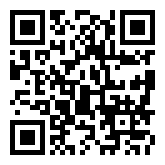

'0x7c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5'

'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX'

In [ ]:
import IPython.display
my_qr=IPython.display.Image('llaves/mi_addr.png')

my_privKey=import_privKey('llaves/mi_prv.enc','')
my_pub=import_pubKey('llaves/mi_pub.bin')
my_addr=import_addr('llaves/mi_addr.bin')

display(my_qr)
display(my_pub)
display(my_addr)

In [ ]:
pub2=eth_keys.keys.PublicKey(bytes.fromhex(p2hex))
pub2

'0x2478459160f8e4563ad84a1faa998158c2e47b3c8eac04654ca30f892d4c873db08339cabb0f5c775f1f798919ab4ce5772666a88ea39cf811b73c95d28ee9f9'

In [ ]:
pub3=eth_keys.keys.PublicKey(bytes.fromhex(p3hex))
pub3

'0x5701dec1853f3b5eb1039bea648438ff90c95a97fb0b601b0ce8aaf476a5c73f4c42a1f00c5b09cebcc8ed8f9c2663e1cbd2601376cf5fc226569b22c0239c73'

In [ ]:
#make list of shared secrets
our_shared_keys=[ shared_key(prvKey=my_privKey,pubKey=p) for p in [my_pub,pub2,pub3]]

In [ ]:
locked_keys=[ ecies.aes_encrypt(sharekey,session_aes) for sharekey in our_shared_keys ]
#key_prepend=len(locked_keys).to_bytes(1,'big')+b''.join(locked_keys)
key_prepend=b''.join(locked_keys)
print(key_prepend)
print(len(key_prepend))

b'\xc8UK:\x97jB\xa3Tr,U\x00\xa0Lz\x97\xf9fx\x8a\xca\xf2\xf2\xe5\xa1\x93*Fs\xb01\x93f\xfe|M5\xdc\x81\xae\x8b\x0f9\xe3\xad\xbe\xe1\x0f\xdc\x11\xa1\x16U\x9b0\x1f-\'OF?M\nT\x1c\xce\xfc\xfc\xe1+"4\xb2\x83\xe9\x88(\xc5V\xa0J\xfc\xbd\xcf\xe76c9\xf19p!\xdb\xd9Q:\x7f\x17n:\xf7\xe7\x92\xd4;\xae\xa8\xe59p\xbdA/;\xf1\xad\xe0*w\x1b\xa0>CH@k\xd0m\xadT\xadY\xd8\x9f"\xd8\x13\xf2\x84\x1f\x10\xe9q\x04G\xd66p\xe3\xcf\x8e\x81\x06\x14\xab\x9d\xbe\xe9\xdd\x9bH\xaf\xd4)\xd6\xb3\x0c\xdeX~\xc9@H\xc9\xb4\xdb3\xf3$\x90\nU\x0eC\xba]\xb7\xe1\xad\xba\xd7'
192


In [ ]:
192/3

64.0

In [ ]:


#message=bimg.bytestring
message=key_prepend+enc_img

n=4*80
chunks = [message[i:i+n] for i in range(0, len(message), n)]

print(len(message))
print(len(chunks))
print(len(chunks[0]))
print(len(chunks[-1]))



15584
49
320
224


For encrypted transmissions to single recipients...it is possible to encrypt directly with the shared key (derived from shared secret). This way both sender and recipient will have access without needing to post anything else.

Sometimes we may post an AES encrypted message without any intended recipient. In this case we will use a temporary AES key and encrypt for ourselves using the same protocol. It could be for personal access or the session AES key could be published at some point in the future. In other words, the encoding protocol is identical for the case when the only recipient is ourselves.

In [ ]:
recip_bytes=len(locked_keys).to_bytes(1,'big')
length_bytes=length.to_bytes(2,'big')
width_bytes=width.to_bytes(2,'big')
bitnum_bytes=bit_num.to_bytes(1,'big')
print(recip_bytes)
print(length_bytes)
print(width_bytes)
print(bitnum_bytes)

b'\x03'
b'\x00@'
b'\x00\x80'
b'\x05'


In [ ]:
#04 videos
#05 files
#0e encryption

#For 0e we can declare encoding of encrypted data
#This would be color image

header=b'\xc1\xdd\x00\x01\x0e\x03\x01'+length_bytes+width_bytes+bitnum_bytes+recip_bytes

#For opaque encoding with internal/encryption header we use ...
#header=b'\xc1\xdd\x00\x01\x0e\x0e\x00 + recip_bytes'

header

b'\xc1\xdd\x00\x01\x0e\x03\x01\x00@\x00\x80\x05\x03'

In [ ]:
text='''|This is an encrypted image for two special ladies...Hola|'''.encode() 
print(len(header))
print(len(text))
print(len(header+text))
package=[header+text]+chunks
print(len(package))

13
58
71
50


In [ ]:
import cryptos
doge=cryptos.Doge()
#addy=doge.privtoaddr(privkeyhex)
doge_unspents=doge.unspent(addr) 
doge_unspent_total=sum([unspent['value'] for unspent in doge_unspents])
print(doge_unspent_total/10**8)
print(len(doge_unspents))

1388.9170694
1


In [ ]:
tip=4_00_000_000
available=doge_unspent_total-tip
n=len(package)
gift=int(available/n)
outputs=[{'value':gift , 'address': addr} for i in range(len(package))]
setup_tx=doge.mktx(doge_unspents,outputs)
print(gift/100_000_000)
print(len(outputs))

27.69834138
50


In [ ]:
doge.signall(setup_tx,my_privKey.to_hex()[2:])

'0100000001ebd0ff92f9076106a8fe63bb55f2df67a973e516bf4df7ea9187a4880fba2d9c000000008a47304402206e99957cf49b095b7334a5575a51434f1baddd6a88a19380a2d55a736dee68e4022043269ec078a2cb0b5902db12d4de1019b2d6f3f20ed07221fb0431f3b82232730141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5ffffffff329a5018a5000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac9a5018a5000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac9a5018a5000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac9a5018a5000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac9a5018a5000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac9a5018a5000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac9a5018a5000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac9a5018a5000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac9a5018a5000000001976a914144739367df0ff8d1c61d03704298d49cf93ef3f88ac9a5018a5000000001

In [ ]:
tip/(len(cryptos.serialize(setup_tx))/2)/100000

2.1175224986765486

In [ ]:
funding=doge.pushtx(cryptos.serialize(setup_tx))
funding

{'data': {'network': 'DOGE',
  'txid': 'd0209a0f85872d6826c58bc23fab37c8b21feb22c15a5a6469f45358fb78ba41'},
 'status': 'success'}

```d68175766b70f7163aec93e5a4e81480a6c6dd51d0577319d6f3392e8725f53b```

```d0209a0f85872d6826c58bc23fab37c8b21feb22c15a5a6469f45358fb78ba41```

In [ ]:
doge.fetchtx(funding['data']['txid'])['confirmations']

2

In [ ]:
class Cadena():

  def __init__(self,prvkey,data,utxo_dct,tip):
    self.data=data
    self.doge=cryptos.Doge()
    self.clip=[self.data[i:i+80] for i in range(0,len(self.data),80) ]
    self.og_len=len(self.clip)
    self.state='CONF'
    self.utxo=utxo_dct
    self.head_utxo=self.utxo
    self.txn_ids=[self.utxo['output'].split(':')[0]]
    self.prv=prvkey
    self.addr=self.doge.privtoaddr(self.prv)
    self.tip=tip
    self.index=0

  def make_tx(self):
    tx = self.doge.mktx([self.head_utxo],[ {'value':self.head_utxo['value']-self.tip , 'address': self.addr}])
    doge_inscribed_serial_tx=mk_opreturn( self.clip[self.index] , cryptos.serialize(tx))
    doge_inscribed_tx=cryptos.deserialize(doge_inscribed_serial_tx)
    self.signed_inscribed_tx=self.doge.signall(doge_inscribed_tx,self.prv)
    self.state='READY'
  
  def broadcast(self):
    self.cast=self.doge.pushtx(self.signed_inscribed_tx)
    cast_txid=self.cast['data']['txid']
    self.txn_ids.append(cast_txid)
    self.head_utxo={'output':cast_txid+':0' ,'value':self.head_utxo['value']-self.tip }
    self.index=self.index+1
    self.state='SENT'

  def update(self):
    if self.doge.fetchtx(self.head_utxo['output'].split(':')[0])['confirmations']:
      self.state='CONF'
      if self.index==self.og_len:
        self.state='DONE'

import pandas as pd
from cryptos.py3specials import safe_hexlify, from_string_to_bytes, from_int_to_byte, from_string_to_bytes
from cryptos import serialize,deserialize

def only_conf(utxos):
    return [utxo for utxo in utxos
            if doge.fetchtx(utxo['output'].split(':')[0])['confirmations']>0]

def mk_opreturn(msg, rawtx=None, json=0):
    
    def op_push(data):
        if type(data) == bytes:
            bytedata=data
        else:
            bytedata=data.encode()
        import struct
        if len(data) < 0x4c:
            return from_int_to_byte(len(bytedata)) + bytedata
        elif len(data) < 0xff:
            return from_int_to_byte(76) + struct.pack('<B', len(bytedata)) + bytedata
        elif len(data) < 0xffff:
            return from_int_to_byte(77) + struct.pack('<H', len(bytedata)) + bytedata
        elif len(data) < 0xffffffff:
            return from_int_to_byte(78) + struct.pack('<I', len(bytedata)) + bytedata
        else: raise Exception("Input data error. Rawtx must be hex chars" \
                            + "0xffffffff > len(data) > 0")

    orhex = safe_hexlify(b'\x6a' + op_push(msg))
    orjson = {'script' : orhex, 'value' : 0}
    if rawtx is not None:
        try:
            txo = deserialize(rawtx)
            if not 'outs' in txo.keys(): raise Exception("OP_Return cannot be the sole output!")
            txo['outs'].append(orjson)
            newrawtx = serialize(txo)
            return newrawtx
        except Exception as E:
            print(E)
            print(type(E))
            raise Exception("Raw Tx Error!")
    return orhex if not json else orjson

In [ ]:
sparkle_unspents=only_conf(doge.unspent(addr) )

In [ ]:
len(sparkle_unspents)

50

In [ ]:
cadenas=[ Cadena(privKey.to_hex()[2:],*datum_utxo,100_000_000)for datum_utxo in zip(package,sparkle_unspents) ]

In [ ]:
import time

height=doge.current_block_height()-1
print(height)
while True:
  check_height=doge.current_block_height()
  if check_height>height:
    height=check_height
    print(height)
    [cad.make_tx() for cad in cadenas if cad.state=='CONF'];
    [cad.broadcast() for cad in cadenas if cad.state=='READY'];
    [cad.update() for cad in cadenas if cad.state=='SENT'];
    [cad.make_tx() for cad in cadenas if cad.state=='CONF'];
    [cad.broadcast() for cad in cadenas if cad.state=='READY'];
    print([cad.state for cad in cadenas])
    if all([cad.state=='DONE' for cad in cadenas]):
      break
  time.sleep(10)


4252447
4252448
['SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT']
4252449
['SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT']
4252450
['DONE', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT', 'SENT

In [ ]:
doge.privtopub(my_privKey.to_hex()[2:])

'047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5'

In [ ]:
addys=[doge.pubtoaddr(bytes.fromhex('04'+p.to_hex()[2:])) for p in [my_pub,pub2,pub3]]
addys

['D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX',
 'DJBkcc9zShCCWPTvPuLUiHQegNPbmMipEH',
 'DJ8tHm9dkR9KYTRWYeEPa5iXEygattqqsd']

In [ ]:
doge_unspents=doge.unspent(addr) 
doge_unspent_total=sum([unspent['value'] for unspent in doge_unspents])
tip=20_00_000_000
available=doge_unspent_total-tip

outputs=[{'value':doge_unspent_total-tip-4_00_000_000 , 'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX'},
         {'value':2_00_000_000 , 'address': 'DJBkcc9zShCCWPTvPuLUiHQegNPbmMipEH'},
         {'value':2_00_000_000 , 'address': 'DJ8tHm9dkR9KYTRWYeEPa5iXEygattqqsd'}]
close_tx=doge.mktx(doge_unspents,outputs)

In [ ]:
doge.signall(close_tx,my_privKey.to_hex()[2:])

'010000003296b69d11731184ee491046a23bcc11dbeee70e278427eb7ace4d88ce3cf7b75f000000008b483045022100db525923f5dc0d4db108777191a292e55060dbc1a26c16102c75ad665de3ff800220301d1848309c45dd9944f8f48733ef589b426d88e90daa550284b86e1de6d8a80141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5ffffffffd4648b44f728372910015130d2b18a00f16566986c95e128ab869a480543ea86000000008a4730440220448e2234cb9d395b4bfdacf857d55a737c75fbf7c92b341427efc537cd4a3712022012b3cf36f54f3868ae4ce85ee97d86d63284c0fbb75c23414881c541af180ae10141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5fffffffffec022dc4627eb8be1053f6c1f5ac88ff3dfec09a33d57bb41f90822b304d7ee000000008b483045022100bd226725e7b44a3e1abdad07f2b9589516d265215b7174cd0669c14826539af202205affdccd4bdcfba8ae77edc78216a4b2e63b36e689f2975df535421e9defcc770141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b

In [ ]:
tip/(len(cryptos.serialize(close_tx))/2)/100000

2.1997360316761987

In [ ]:
closing=doge.pushtx(cryptos.serialize(close_tx))
closing

{'data': {'network': 'DOGE',
  'txid': '22f2bb75129b01d2ccef433bbd4ce928fa1a65cb471ee1e4d895f8b861afc769'},
 'status': 'success'}

In [ ]:
doge.fetchtx(closing['data']['txid'])['confirmations']

320

# Now Read

In [5]:
def get_output_spend_txns(txn_ident):
  import requests
  import json
  r = requests.get(f'https://sochain.com/api/v2/tx/DOGE/{txn_ident}')
  return [out['spent']['txid'] for out in json.loads(r.text)['data']['outputs']]

def get_op_return(txn_ident):
  import requests
  import json
  r = requests.get(f'https://sochain.com/api/v2/tx/DOGE/{txn_ident}')
  outs=json.loads(r.text)['data']['outputs']
  asm=outs[-1]['script_asm']
  return (asm[10:] if 'OP_RETURN' in asm else None),outs[0]['spent']['txid'] if outs[0]['spent'] else None

def get_op_returns(tx_head,prefix=''):
  import time
  time.sleep(0.25)
  op_ret,next_txn=get_op_return(tx_head)
  if (op_ret and next_txn):
    return get_op_returns(next_txn,prefix+op_ret)
  if op_ret==None:
    return prefix
  else:
    return prefix+op_ret

def read_cadenas(txn_ident):
  datalist=[get_op_returns(txn) for txn in get_output_spend_txns(txn_ident)]
  return datalist[0],b''.join([bytes.fromhex(x) for x in datalist[1:] ])

In [ ]:
(head_d02,bytes_d02)=read_cadenas('d0209a0f85872d6826c58bc23fab37c8b21feb22c15a5a6469f45358fb78ba41')

In [ ]:
print(head_d02)
print(bytes.fromhex(head_d02).decode('latin'))

c1dd00010e03010040008005037c5468697320697320616e20656e6372797074656420696d61676520666f722074776f207370656369616c206c61646965732e2e2e486f6c617c
ÁÝ  @ |This is an encrypted image for two special ladies...Hola|


In [ ]:
num_keys=int(head_d02[24:26])
zipkeys=[bytes_d02[i*64:i*64+64] for i in range(num_keys) ]
zipdata=bytes_d02[num_keys*64:]

In [ ]:
def get_txn_pub(txn_ident):
  import requests
  import json
  r = requests.get(f'https://sochain.com/api/v2/tx/DOGE/{txn_ident}')
  ins=json.loads(r.text)['data']['inputs']
  publica=ins[0]['script_asm'][-128:]
  return publica

In [ ]:
#this is the 
txn_pub_hex=get_txn_pub('d0209a0f85872d6826c58bc23fab37c8b21feb22c15a5a6469f45358fb78ba41')
txn_pub_hex

'7c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5'

In [ ]:
txn_pubKey=eth_keys.keys.PublicKey(bytes.fromhex(txn_pub_hex))
txn_pubKey

'0x7c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5'

In [ ]:
my_pub

'0x7c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5'

In [ ]:
my_shared_key=shared_key(my_privKey,txn_pubKey)


In [ ]:
ses_kee=ecies.aes_decrypt(my_shared_key,zipkeys[0])
data_do2=ecies.aes_decrypt(ses_kee,zipdata)

In [6]:
def read_image_data(hex_header,image_bytes):
  C={0:1,1:3}[int(hex_header[12:14],16)]
  L=int(hex_header[14:18],16)
  W=int(hex_header[18:22],16)
  B=int(hex_header[22:24],16)
  print(C,L,W,B)
  sparkle_bits=message_2_bit_array(image_bytes,mode=None)
  spark_array=bitarray2imgarr(sparkle_bits,imgshape=(W,L),bit=B,color=C).squeeze()
  return spark_array

In [7]:
array_do2=read_image_data(head_d02,data_do2)

NameError: ignored

In [ ]:
Image.fromarray(array_do2)

In [8]:
def array_dec_from_txn(txn_ident,prvKey_input,index_key):
  hex_header,enc_bytes=read_cadenas(txn_ident)
  N_keys=int(hex_header[24:26])
  Zipkeys=[enc_bytes[i*64:i*64+64] for i in range(N_keys) ]
  Zipdata=enc_bytes[N_keys*64:]
  Txn_pub=eth_keys.keys.PublicKey(bytes.fromhex(get_txn_pub(txn_ident)))
  Shared_key=shared_key(prvKey_input,Txn_pub)
  Ses_key=ecies.aes_decrypt(Shared_key,Zipkeys[index_key])
  Data=ecies.aes_decrypt(Ses_key,Zipdata)
  return hex_header,read_image_data(hex_header,Data)


In [9]:

(d68_head,d68_array)=array_dec_from_txn('d68175766b70f7163aec93e5a4e81480a6c6dd51d0577319d6f3392e8725f53b',my_privKey,0)

NameError: ignored

In [ ]:
Image.fromarray(d68_array)